In [1]:
import pandas as pd
from pathlib import Path
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
from statsmodels.stats.multitest import multipletests
from scipy.cluster.hierarchy import linkage, leaves_list

In [2]:
# PARAMETERS
run_id="group_loops.09.19.ldcts"

In [3]:
# Parameters
run_id = "msn.hypo.12.02.ldcts"

In [4]:
selected_traits = {
    "Bellenguez.NatGenet.2022.Alzheimers_Disease_Dementia_" : "Alzheimers Disease and Dementia", 
    "Nalls.LancetNeurol.2019.Parkinsons_disease_" : "Parkinson's Disease", 
    "PGC.Nature.2014.Schizophrenia_" : "Schizophrenia", 
    "Wray.biorxiv.2018.Major_Depressive_Disorder_" : "Major Depressive Disorder", 
    "Demontis.NatGenet.2019.Attention_Deficit_Hyperactivity_Disorder_" : "ADHD", 
    "Mullins.NatGenet.2021.Bipolar_Disorder_" : "Bipolar Disorder", 
    "Grove.NatGenet.2019.Autism_Spectrum_Disorder_" : "Autism Spectrum Disorder", 
    "Jansen.2019.NatGenet.Insomnia_" : "Insomnia", 
    "PGC.MolPsychiatry.2017.Obsessive_Compulsive_Disorder_" : "Obsessive Compulsive Disorder", 
    "Deary.MolPsychiatry.2017.Tiredness_" : "Tiredness", 
    "IMSGC.Science.2019.Multiple_sclerosis_" : "Multiple Sclerosis", 
    "Luciano.NatGenet.2017.Neuroticism_" : "Neuroticism", 
    "Okbay.Nature.2016.Educational_Attainment_" : "Educational Attainment", 
    "Palmer.MolPsych.2021.problematic_opioid_use_" : "Problematic Opioid Use", 
    "Savage.NatGenet.2018.Intelligence_" : "Intelligence", 
    "vanRheenen.NatGenet.2016.Amyotrophic_Lateral_Sclerosis_" : "Amyotrophic Lateral Sclerosis", 
    "Barban.NatGenet.2016.Age_First_Birth_" : "Age at First Birth", 
    "Chiou.Nature.2021.Type_1_diabetes_" : "Type 1 Diabetes", 
    "Watson.2018.NatGenet.Anorexia_Nervosa_" : "Anorexia Nervosa"
}

In [5]:
ldsc_results=f'/anvil/projects/x-mcb130189/rwang22/bican/ldsc/output/{run_id}'
directory = Path(ldsc_results)
dfs = {}

for file in directory.glob(f'*.cell_type_results.txt'):
    cur = pd.read_csv(file, sep = "\t")
    stripped = file.stem.replace(f'_.cell_type_results', "")
    cur["Trait"] = stripped
    dfs[stripped] = cur

In [6]:
combined_df = pd.concat(dfs.values(), ignore_index=True)
combined_df["-log10(pval)"] = -np.log10(combined_df["Coefficient_P_value"])
combined_df["Trait"] = combined_df["Trait"].str.replace(f'{run_id}.cell_type_results', "")
combined_df = combined_df[combined_df["Trait"].isin(selected_traits.keys())] # only predetermined selected traits
combined_df.head()

,Name,Coefficient,Coefficient_std_error,Coefficient_P_value,Trait,-log10(pval)
18,STR_D1D2_Hybrid_MSN,2.890248e-08,2.493176e-08,0.123174,Barban.NatGenet.2016.Age_First_Birth_,0.909480
19,STRv_D1_NUDAP_MSN,3.266269e-08,3.516152e-08,0.176462,Barban.NatGenet.2016.Age_First_Birth_,0.753349
20,STRd_D2_StrioMat_Hybrid_MSN,2.569971e-08,3.239527e-08,0.213797,Barban.NatGenet.2016.Age_First_Birth_,0.669999
21,STRv_D1_MSN,-1.994648e-08,5.298978e-08,0.646698,Barban.NatGenet.2016.Age_First_Birth_,0.189298
22,STRd_D1_Matrix_MSN,-2.374486e-08,4.715126e-08,0.692725,Barban.NatGenet.2016.Age_First_Birth_,0.159439


In [7]:
# Perform FDR correction using Benjamini-Hochberg procedure
rejected, q_values, _, _ = multipletests(combined_df["Coefficient_P_value"], alpha=0.05, method='fdr_bh')
combined_df["FDR_BH_corrected"] = q_values

In [8]:
# calculate the FDR p value threshold 
# https://www.r-bloggers.com/2023/07/the-benjamini-hochberg-procedure-fdr-and-p-value-adjusted-explained/

def fdr_bh_adj(df):
    tmp = combined_df.copy()
    tmp["rank"] =  combined_df['Coefficient_P_value'].rank()
    num_tests = len(tmp)
    tmp["adj_pval"] = (num_tests * tmp["Coefficient_P_value"]) / tmp["rank"]

    return tmp


In [9]:
tmp = fdr_bh_adj(combined_df)
# Align indices before comparison
fdr_bh_corrected = combined_df["FDR_BH_corrected"]
adj_pval = tmp["adj_pval"]

print(fdr_bh_corrected.sort_values())

144     0.416054
145     0.416054
146     0.421428
1044    0.421428
63      0.543675
          ...   
908     0.999236
150     0.999236
134     0.999236
818     0.999236
1052    0.999236
Name: FDR_BH_corrected, Length: 171, dtype: float64


In [10]:
print(adj_pval.sort_values())

145     0.416054
1044    0.421428
146     0.430714
63      0.543675
144     0.593368
          ...   
818     1.058577
792     1.096993
1017    1.195224
900     1.252384
811     1.255747
Name: adj_pval, Length: 171, dtype: float64


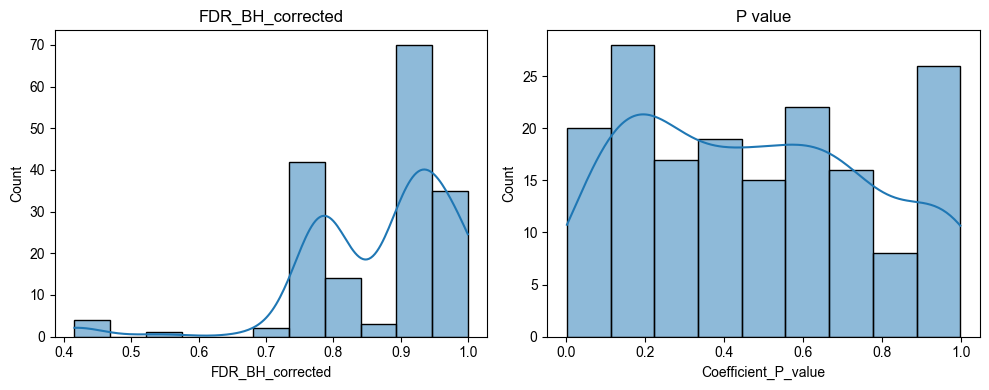

In [11]:
# plot the distribution of p values 
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# First plot
sns.histplot(combined_df["FDR_BH_corrected"], kde=True, ax=axes[0])
axes[0].set_title("FDR_BH_corrected")

# Second plot
sns.histplot(combined_df["Coefficient_P_value"], kde=True, ax=axes[1])
axes[1].set_title("P value")

plt.tight_layout()
plt.show()

In [12]:
modified_df = combined_df.drop(['Coefficient', 'Coefficient_std_error', 'Coefficient_P_value', 'FDR_BH_corrected'], axis=1)
modified_df = modified_df.pivot(index="Name", columns="Trait", values="-log10(pval)").reset_index()
modified_df = modified_df.set_index("Name")
modified_df.head()

Trait,Barban.NatGenet.2016.Age_First_Birth_,Bellenguez.NatGenet.2022.Alzheimers_Disease_Dementia_,Chiou.Nature.2021.Type_1_diabetes_,Deary.MolPsychiatry.2017.Tiredness_,Demontis.NatGenet.2019.Attention_Deficit_Hyperactivity_Disorder_,Grove.NatGenet.2019.Autism_Spectrum_Disorder_,IMSGC.Science.2019.Multiple_sclerosis_,Jansen.2019.NatGenet.Insomnia_,Luciano.NatGenet.2017.Neuroticism_,Mullins.NatGenet.2021.Bipolar_Disorder_,Nalls.LancetNeurol.2019.Parkinsons_disease_,Okbay.Nature.2016.Educational_Attainment_,PGC.MolPsychiatry.2017.Obsessive_Compulsive_Disorder_,PGC.Nature.2014.Schizophrenia_,Palmer.MolPsych.2021.problematic_opioid_use_,Savage.NatGenet.2018.Intelligence_,Watson.2018.NatGenet.Anorexia_Nervosa_,Wray.biorxiv.2018.Major_Depressive_Disorder_,vanRheenen.NatGenet.2016.Amyotrophic_Lateral_Sclerosis_
Name,,,,,,,,,,,,,,,,,,,
STR_D1D2_Hybrid_MSN,0.909480,0.108517,0.662367,0.415383,1.086417,0.353017,0.532519,0.304799,0.030831,0.220774,0.151276,0.342557,0.175992,0.208084,0.661185,1.135258,0.091574,0.576159,0.028597
STRd_D1_Matrix_MSN,0.159439,0.765258,0.035290,0.268591,0.037714,0.128795,0.176905,0.229989,0.224612,0.296180,1.179851,0.006915,0.319567,0.002766,0.134596,0.044273,0.157357,0.219528,2.459672
STRd_D1_Striosome_MSN,0.013002,0.587783,0.426889,0.025405,0.751297,0.525288,0.368125,0.021788,0.097966,0.208703,0.767042,0.001096,0.764332,0.127586,0.000332,0.003809,0.590752,0.001982,1.544268
STRd_D2_Matrix_MSN,0.106940,0.391434,0.003984,0.647996,0.111921,0.130564,0.079599,0.242324,1.026294,0.768078,1.368181,0.102796,0.403732,0.358332,0.179003,0.144045,0.171193,0.655188,2.121686
STRd_D2_StrioMat_Hybrid_MSN,0.669999,0.253264,1.798687,0.366933,0.163580,0.364555,0.989910,0.712317,0.539639,1.023913,0.359498,0.687226,1.107743,0.784357,0.196456,0.404193,1.032117,0.484514,0.008230


In [13]:
fdr_modified_df = combined_df.drop(['Coefficient', 'Coefficient_std_error', 'Coefficient_P_value', '-log10(pval)'], axis=1)
fdr_modified_df = fdr_modified_df.pivot(index="Name", columns="Trait", values="FDR_BH_corrected").reset_index()
fdr_modified_df = fdr_modified_df.set_index("Name")
fdr_modified_df.head()

Trait,Barban.NatGenet.2016.Age_First_Birth_,Bellenguez.NatGenet.2022.Alzheimers_Disease_Dementia_,Chiou.Nature.2021.Type_1_diabetes_,Deary.MolPsychiatry.2017.Tiredness_,Demontis.NatGenet.2019.Attention_Deficit_Hyperactivity_Disorder_,Grove.NatGenet.2019.Autism_Spectrum_Disorder_,IMSGC.Science.2019.Multiple_sclerosis_,Jansen.2019.NatGenet.Insomnia_,Luciano.NatGenet.2017.Neuroticism_,Mullins.NatGenet.2021.Bipolar_Disorder_,Nalls.LancetNeurol.2019.Parkinsons_disease_,Okbay.Nature.2016.Educational_Attainment_,PGC.MolPsychiatry.2017.Obsessive_Compulsive_Disorder_,PGC.Nature.2014.Schizophrenia_,Palmer.MolPsych.2021.problematic_opioid_use_,Savage.NatGenet.2018.Intelligence_,Watson.2018.NatGenet.Anorexia_Nervosa_,Wray.biorxiv.2018.Major_Depressive_Disorder_,vanRheenen.NatGenet.2016.Amyotrophic_Lateral_Sclerosis_
Name,,,,,,,,,,,,,,,,,,,
STR_D1D2_Hybrid_MSN,0.777382,0.961704,0.784881,0.898568,0.777382,0.898568,0.809781,0.912528,0.999236,0.935687,0.935687,0.903525,0.935687,0.935687,0.784881,0.777382,0.968470,0.801004,0.999236
STRd_D1_Matrix_MSN,0.935687,0.777382,0.999236,0.930614,0.999236,0.943087,0.935687,0.935687,0.935687,0.912528,0.777382,0.999236,0.909910,0.999236,0.943087,0.999236,0.935687,0.935687,0.416054
STRd_D1_Striosome_MSN,0.999236,0.801004,0.898568,0.999236,0.777382,0.809781,0.898568,0.999236,0.967061,0.935687,0.777382,0.999236,0.777382,0.943087,0.999236,0.999236,0.801004,0.999236,0.697639
STRd_D2_Matrix_MSN,0.961704,0.898568,0.999236,0.784881,0.961704,0.943087,0.988632,0.935687,0.777382,0.777382,0.777382,0.963990,0.898568,0.898568,0.935687,0.943087,0.935687,0.784881,0.421428
STRd_D2_StrioMat_Hybrid_MSN,0.784881,0.935687,0.543675,0.898568,0.935687,0.898568,0.777382,0.784881,0.809781,0.777382,0.898568,0.784881,0.777382,0.777382,0.935687,0.898568,0.777382,0.864028,0.999236


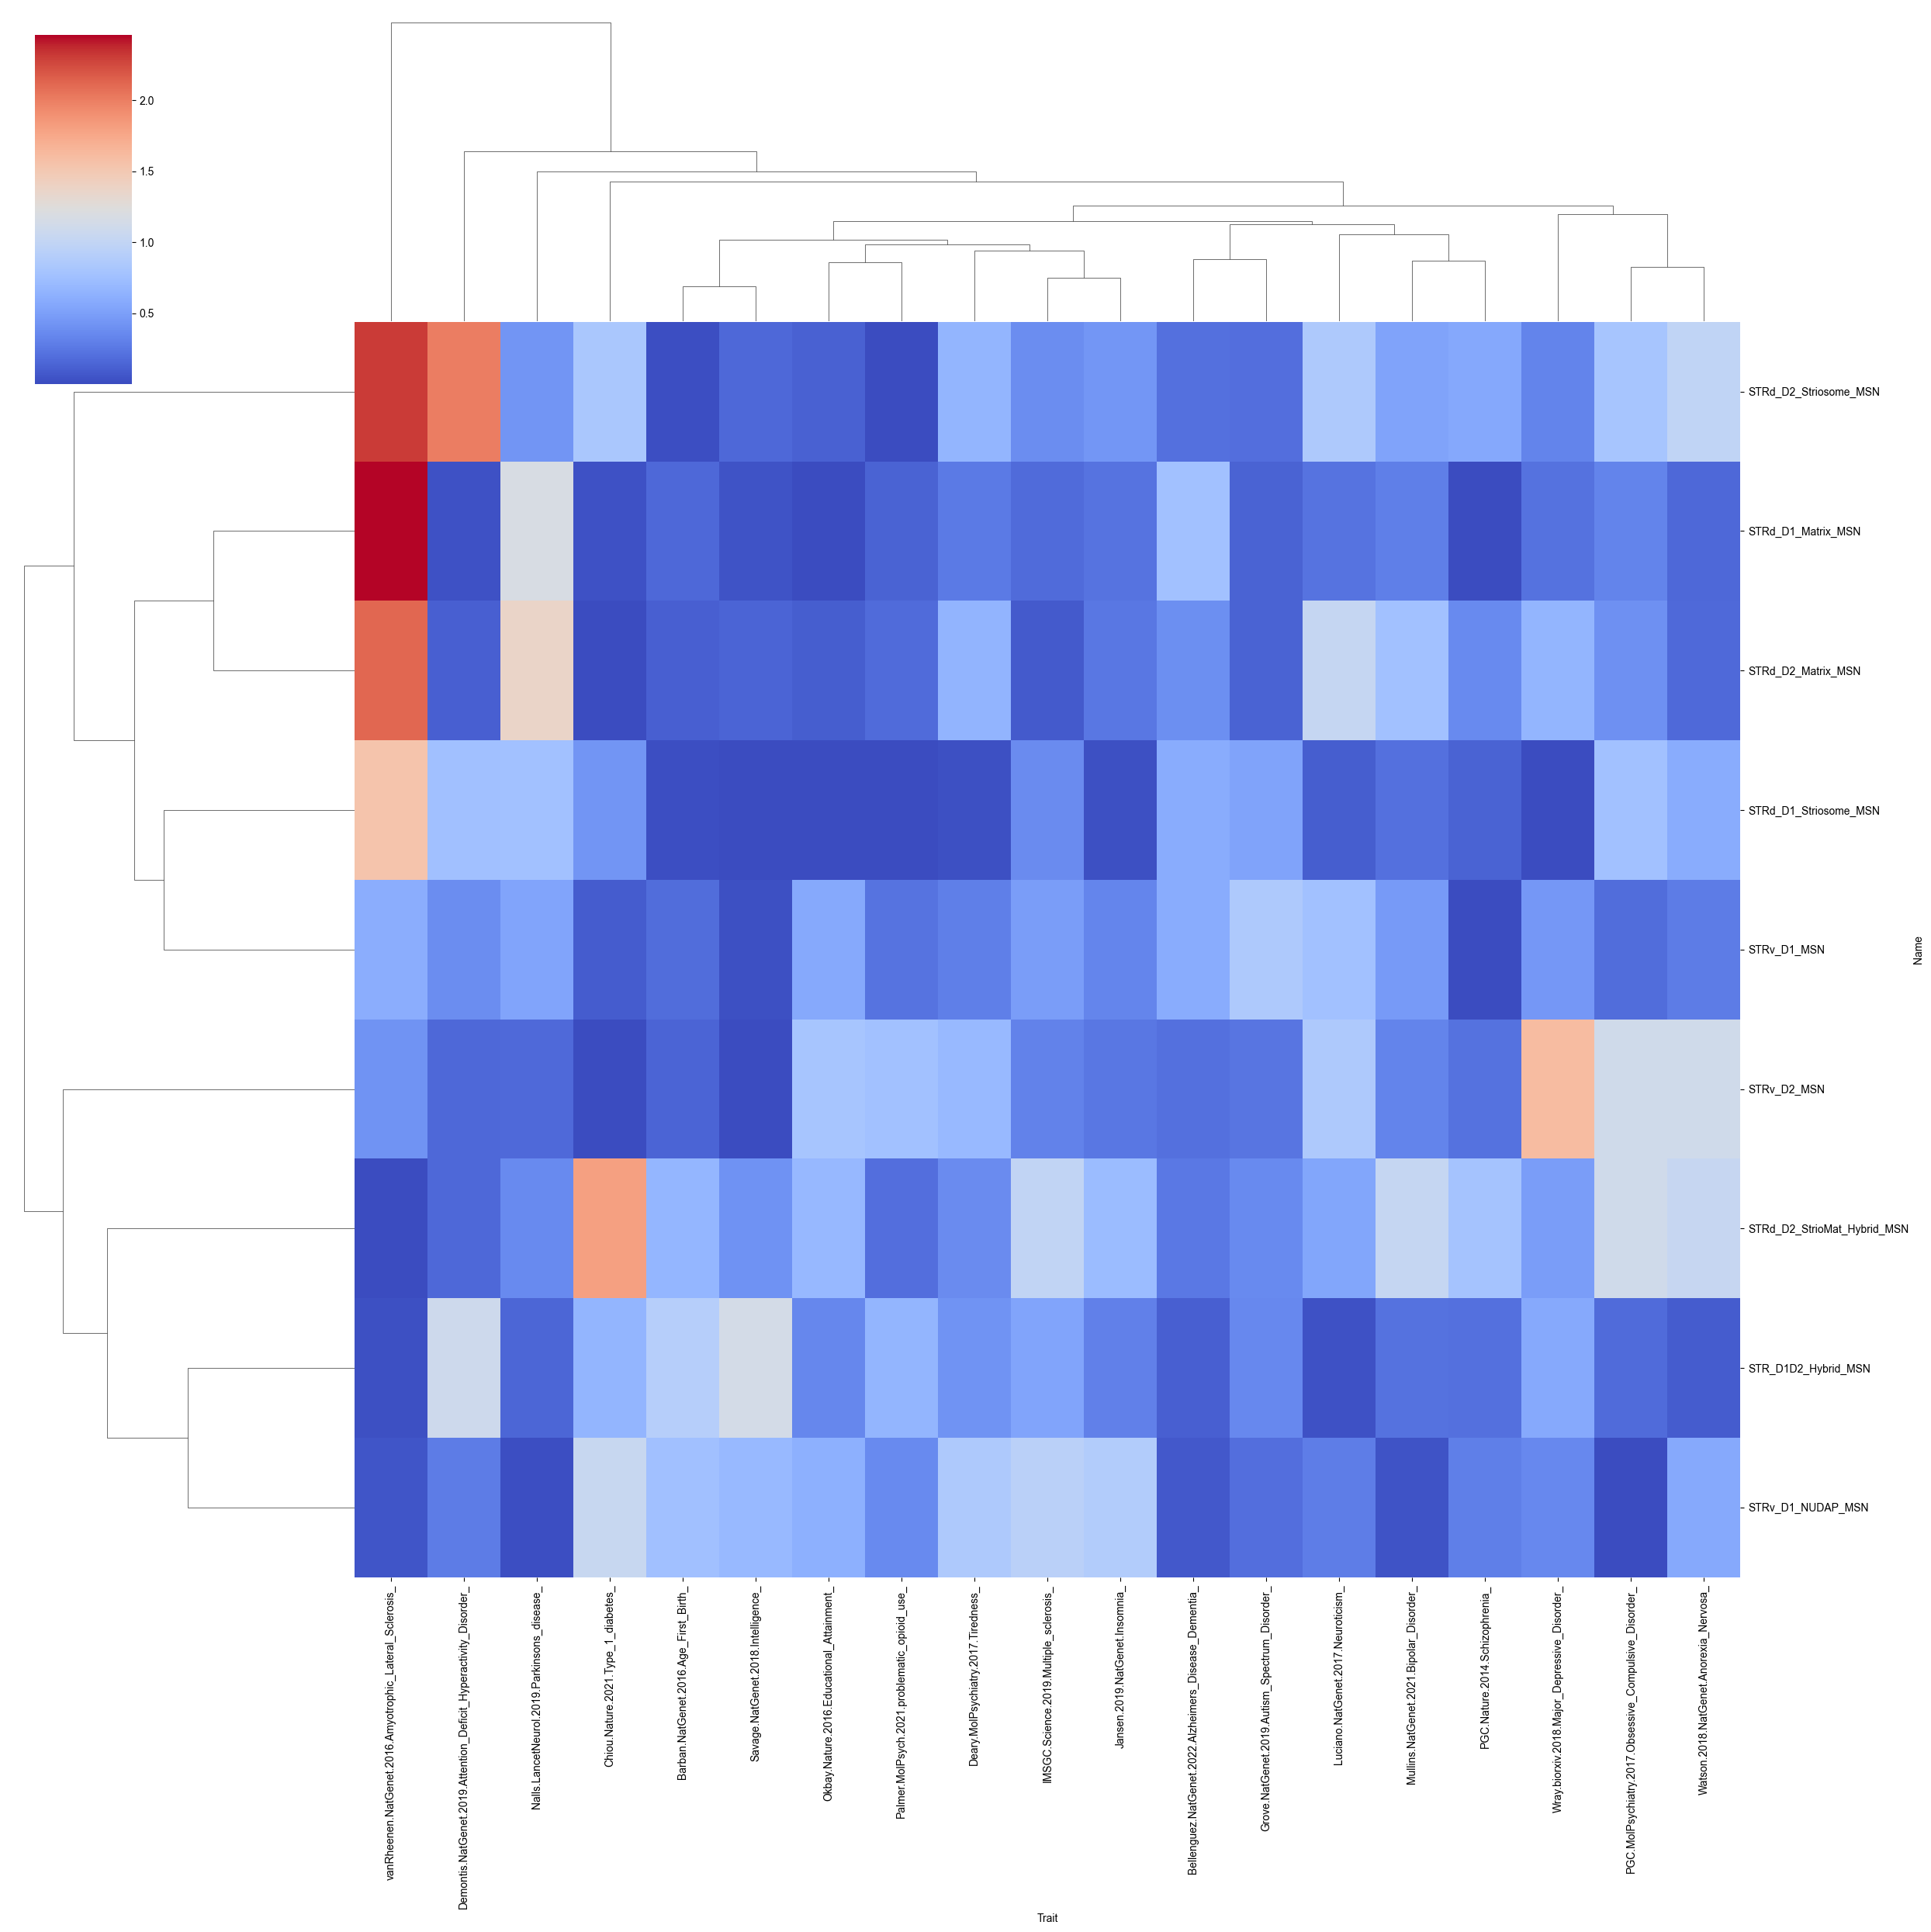

In [14]:
g = sns.clustermap(modified_df, cmap='coolwarm', figsize=(25, 25))

plt.show()
# g.savefig(f'output/{run_id}_filtered.pdf')

In [15]:
def pval_to_star(p):
    if p < 1e-7:
        return '***'
    elif p < 1e-5:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return ''

In [16]:
# Cluster rows
linkage_rows = linkage(modified_df.values, method="average", metric="euclidean")
row_order = leaves_list(linkage_rows)

# Cluster columns
linkage_cols = linkage(modified_df.values.T, method="average", metric="euclidean")
col_order = leaves_list(linkage_cols)

modified_df = modified_df.iloc[row_order, col_order].rename(columns = selected_traits)
fdr_modified_df = fdr_modified_df.iloc[row_order, col_order].rename(columns = selected_traits)

In [17]:
fdr_modified_df = fdr_modified_df.reindex(
    index=modified_df.index,    # same row order as df
    columns=modified_df.columns # same column order as df
)

In [18]:
cols_to_keep = fdr_modified_df.loc[:, (fdr_modified_df < 0.05).any()].columns
cols_to_keep

Index([], dtype='object', name='Trait')

In [19]:
# if len(cols_to_keep) > 0:
#     stars = fdr_modified_df[cols_to_keep].applymap(pval_to_star)

#     # Plot heatmap with annotations
#     plt.figure(figsize=(25, 15))
#     sns.heatmap(modified_df[cols_to_keep], annot=stars, fmt='', cmap='coolwarm')
#     plt.title("-log10(pval) with FDR corrected p value stars")
#     plt.tight_layout()
#     plt.savefig(f'output/{run_id}_filtered_FDR_corrected.pdf')
#     plt.show()
# else:
#     # Plot heatmap with annotations
#     plt.figure(figsize=(16, 8))
#     sns.heatmap(modified_df, fmt='', cmap='coolwarm')
#     plt.title("-log10(pval) with raw p value")
#     plt.tight_layout()
#     plt.savefig(f'output/{run_id}_filtered_raw_pval.pdf')
#     plt.show()

In [20]:
import os
metadata = pd.read_csv(os.path.expanduser("/anvil/projects/x-mcb130189/Wubin/BG/clustering/100kb/annotations.tsv"),sep='\t',index_col=0)
keep_cells=metadata.loc[~ (metadata['Group'].isin(['doublet','Glut','Unk','Low quality cells']))].index.tolist() #,
metadata=metadata.loc[keep_cells]
df_cols = metadata.loc[:,['Subclass','Class','Neighborhood']].drop_duplicates().set_index('Subclass')
df_cols.sort_values(['Neighborhood','Class','Subclass'],inplace=True)
df_cols.head()

,Class,Neighborhood
Subclass,,
F Glut,F M Glut,Glut Sero Dopa
F M Glut,F M Glut,Glut Sero Dopa
M Dopa,M Dopa,Glut Sero Dopa
Astrocyte,Astro-Epen,Nonneuron
Lymphocyte,Immune,Nonneuron


In [21]:
import matplotlib as mpl
mpl.style.use('default')
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = 'Arial'
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi']=300

In [22]:
-np.log10(0.05)

1.3010299956639813

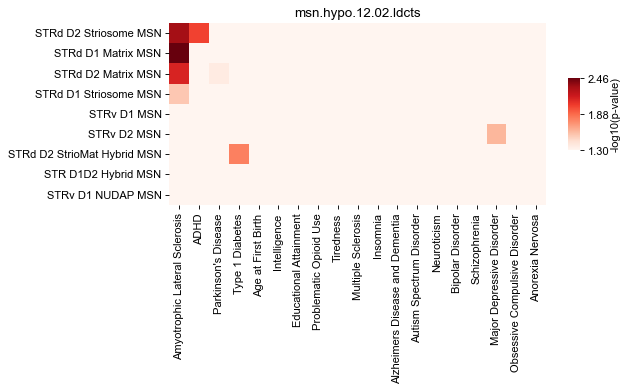

In [24]:
# Plot heatmap with annotations
import os

if len(cols_to_keep) == 0:
    cols_to_keep = modified_df.columns.tolist()

modified_df.index=modified_df.index.to_series().apply(lambda x:x.replace('_',' '))
fdr_modified_df.index=fdr_modified_df.index.to_series().apply(lambda x:x.replace('_',' '))

# row_order=[ct for ct in df_cols.index.tolist() if ct in modified_df.index.tolist()]

vmax=modified_df.loc[: ,cols_to_keep].max().max()

fig, ax = plt.subplots(figsize=(8, 5))
ax=sns.heatmap(modified_df.loc[: ,cols_to_keep], #annot=fdr_modified_df.loc[row_order,cols_to_keep].applymap(pval_to_star), 
               fmt='', cmap='Reds',cbar_kws={'shrink': 0.4,'fraction':0.1,'aspect':6},
               annot_kws=dict(ha='center',va='center'),vmin=1.3,#vmax=4.85,cbar=False
              ax=ax)
# plt.title("-log10(pval) with FDR corrected p value stars")
ax.set_title(run_id)
ax.xaxis.label.set_visible(False)
ax.yaxis.label.set_visible(False)
cbar = ax.collections[0].colorbar
cbar.set_label("-log10(p-value)", fontsize=10, labelpad=1)
cbar.set_ticks([1.3,(1.3+vmax)/2,vmax])
plt.tight_layout()
# plt.savefig(f'{run_id}_fig.pdf')
plt.savefig(os.path.expanduser("~/Projects/BG/pseudobulk/DMR/LDSC_plots/MSN.Group.hypo.LDSC.pdf"),transparent=True,bbox_inches='tight',dpi=300)
plt.show()